# Tarea 2
## Importación de módulos

In [7]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from IPython.display import display

## Clase del problema

In [14]:
class MyProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=3,#Cantidad de genes por cromosoma
                        n_obj=2,#cantidad de funciones objetivo
                        xl=0,#Limite inferior del valor del gen
                        xu=50)#Limite superior del valor de gen
        
    def _evaluate(self, x, out, *args, **kwargs):
        
        # Cantidad de tornos
        T = x[0]
        # Cantidad de fresadoras
        F = x[1]
        # Cantidad de multiproposito
        M = x[2]
        
        #Se definen las penalizaciones por el sobrepaso de material 
        penCab = 280 - (2*T+F+5*M)#Cableado
        penM  = 120 - (6*T+3*F+12*M)#Motores
        penCar = 670 - (2*T+8*F+4*M)#Carcasas
        penA = 250 - (2*T+6*F+6*M)#Actuadores
        
        penalizaciones = [penCab, penM, penCar, penA] #Vector con las penalizaciones
        
        pen = 0
        #Sumatoria de penalizaciones
        for i in range(4):
            if penalizaciones[i] < 0:
                pen = pen + penalizaciones[i]
        
        #Funciones objetivo
        f1 = -(4*T+8*F+12*M)+15*pen**2 #Funcion que busca la mayor ganancia
        f2 = (abs(T-F)+abs(T-M)+abs(F-M))#Funcion que busca la cantidad de unidades sea uniforme
        
        out["F"] = [f1, f2]
        
problem = MyProblem()    

## Inicialización del algoritmo

In [20]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.mutation.pm import PM
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair

# Se utiliza el algoritmo NSGA2 
#Automaticamente se utiliza un el algoritmo de torneo para la selección del cruzamiento
algorithm = NSGA2(pop_size=200,#Numero de la poblacion inicial 
                sampling=IntegerRandomSampling(),
                crossover=SBX(prob=1.0, vtype=float, repair=RoundingRepair()),#Algoritmo de cruce
                mutation=PM(prob=0.05, vtype=float, repair=RoundingRepair()),#Mutacion
                eliminate_duplicates = True)

## Criterio de parada

In [21]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 100)#Cantidad de generaciones

## Optimización

In [22]:
from pymoo.optimize import minimize
#Se utiliza una funcion de minimización para minimizar las funciones objetivo
res = minimize(problem,
            algorithm,
            termination,
            seed=1,
            save_history=True,
            verbose=True)
X = res.X #Vector de soluciones
F = res.F #Vector con las calidades de cada individuo

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      5 |             - |             -
     2 |      400 |      5 |  0.0802132889 |             f
     3 |      600 |      8 |  0.0534340953 |             f
     4 |      800 |     10 |  0.1777777778 |         ideal
     5 |     1000 |     15 |  0.1964285714 |         ideal
     6 |     1200 |     19 |  0.0167414883 |             f
     7 |     1400 |     23 |  0.0344827586 |         ideal
     8 |     1600 |     28 |  0.0077071328 |             f
     9 |     1800 |     30 |  0.0050161661 |             f
    10 |     2000 |     30 |  0.1153846154 |         nadir
    11 |     2200 |     30 |  0.1304347826 |         nadir
    12 |     2400 |     32 |  0.0416666667 |         ideal
    13 |     2600 |     33 |  0.0014825503 |             f
    14 |     2800 |     31 |  0.0058003284 |             f
    15 |     3000 |     31 |  0.0021314649 |             f
    16 |     3200 |     31 |  0.0036306377 |            

## Visualización de Resultados

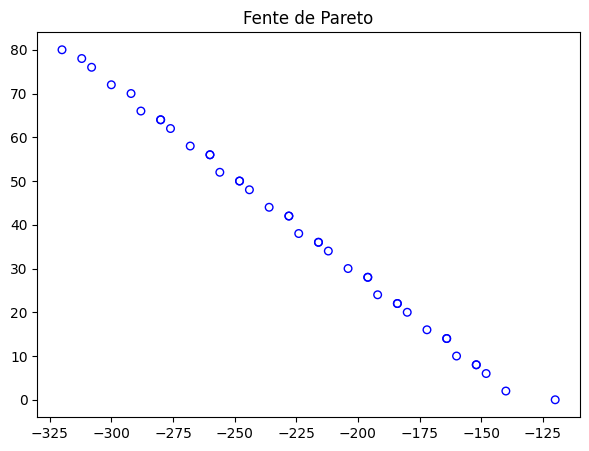

In [23]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Fente de Pareto")
plt.show()

## Mejor resultado por medio de Compromise Programing 

Best regarding ASF: Point 
i = 16
F = [-224.   38.]
X = [ 3 22  3]


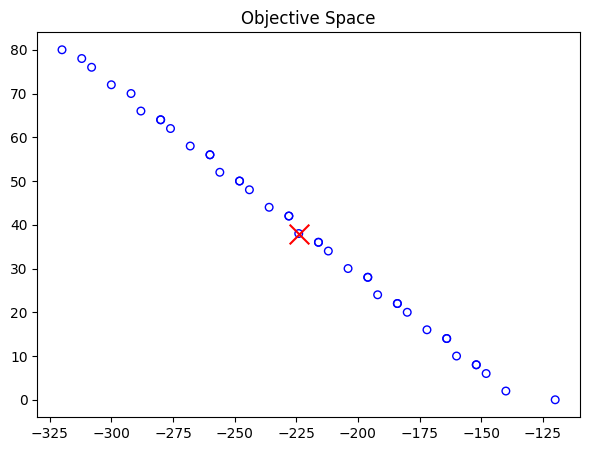

In [24]:
from pymoo.decomposition.asf import ASF
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

weights = np.array([0.5, 0.5])#Peso que determina la importacia de las soluciones
decomp = ASF()
i = decomp.do(nF, 1/weights).argmin()
print("Best regarding ASF: Point \ni = %s\nF = %s\nX = %s" % (i, F[i], X[i]))

#Se grafica el resultado
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()

# Referencias

#### https://pymoo.org/getting_started/index.html
#### https://pymoo.org/customization/discrete.html
#### https://pymoo.org/interface/problem.html
